# Project A: Movies as a Network of Ideas

This notebook prepares the preliminary analysis for Project Assignment A using the MovieLens dataset. We will:

- Download and load MovieLens (latest small) data
- Summarize dataset sizes
- Build a text corpus from user tags per movie
- Construct a movie–movie similarity network from tag semantics (TF-IDF cosine)
- Compute network statistics (nodes, edges, degree distribution summary)
- Run lightweight topic modeling (LDA) on tags
- Tie text and network together via relationships between topic strengths and network centrality
- Emit a filled `ProjectA_video_script.md` for the 1-minute video


In [18]:
# Imports and configuration
import os
import io
import gzip
import zipfile
from pathlib import Path

import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
import networkx as nx

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,5)

BASE_DIR = Path("/Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra")
DATA_DIR = BASE_DIR / "data"
ML_DIR = DATA_DIR / "movielens-latest-small"
DATA_DIR.mkdir(parents=True, exist_ok=True)

ML_SMALL_ZIP_URL = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
ML_SMALL_ZIP_PATH = DATA_DIR / "ml-latest-small.zip"



In [52]:
# Visualization-friendly parameters (tweak for nicer figures)
# You can re-run this cell to experiment for the video
K = 10                 # top-k neighbors per movie for edges
cosine_threshold = 0.10  # lower threshold to increase connectivity
max_nodes_plot = 400    # cap for subgraph plotting (if LCC is huge)
random_seed = 42
np.random.seed(random_seed)

# Text preprocessing configuration
from sklearn.feature_extraction import text as sk_text
custom_stopwords = {
    "netflix", "queue", "movie", "film", "watch", "scene", "scenes",
    "based", "based on", "classic", "new", "old", "best", "worst",
}
stop_words = sk_text.ENGLISH_STOP_WORDS.union(custom_stopwords)
# Token pattern: default (letters/digits, length >= 2)
token_pattern = r"(?u)\b\w\w+\b"



In [45]:
# Download and extract MovieLens (latest small)
import urllib.request

if not ML_SMALL_ZIP_PATH.exists():
    print("Downloading MovieLens latest small ...")
    urllib.request.urlretrieve(ML_SMALL_ZIP_URL, ML_SMALL_ZIP_PATH)
    print("Downloaded:", ML_SMALL_ZIP_PATH)
else:
    print("Zip already exists:", ML_SMALL_ZIP_PATH)

if not ML_DIR.exists():
    print("Extracting ...")
    with zipfile.ZipFile(ML_SMALL_ZIP_PATH, 'r') as zf:
        zf.extractall(DATA_DIR)
    # The zip extracts to a folder named ml-latest-small
    (DATA_DIR / "ml-latest-small").rename(ML_DIR)
    print("Extracted to:", ML_DIR)
else:
    print("Already extracted at:", ML_DIR)



Zip already exists: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/data/ml-latest-small.zip
Already extracted at: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/data/movielens-latest-small


In [53]:
# Load CSVs and summarize sizes
movies_path = ML_DIR / "movies.csv"
ratings_path = ML_DIR / "ratings.csv"
tags_path = ML_DIR / "tags.csv"
links_path = ML_DIR / "links.csv"

movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)
tags = pd.read_csv(tags_path)
links = pd.read_csv(links_path)

summary = {
    "movies_rows": len(movies),
    "movies_cols": list(movies.columns),
    "ratings_rows": len(ratings),
    "ratings_cols": list(ratings.columns),
    "tags_rows": len(tags),
    "tags_cols": list(tags.columns),
    "links_rows": len(links),
    "links_cols": list(links.columns),
}

# Approx MB sizes on disk
summary_sizes = {}
for pth, name in [
    (movies_path, "movies.csv"),
    (ratings_path, "ratings.csv"),
    (tags_path, "tags.csv"),
    (links_path, "links.csv"),
]:
    size_mb = os.path.getsize(pth) / (1024*1024)
    summary_sizes[name] = round(size_mb, 2)

print("Dataset summary:")
print(pd.Series(summary))
print("\nFile sizes (MB):")
print(pd.Series(summary_sizes))



Dataset summary:
movies_rows                                     9742
movies_cols                 [movieId, title, genres]
ratings_rows                                  100836
ratings_cols    [userId, movieId, rating, timestamp]
tags_rows                                       3683
tags_cols          [userId, movieId, tag, timestamp]
links_rows                                      9742
links_cols                 [movieId, imdbId, tmdbId]
dtype: object

File sizes (MB):
movies.csv     0.47
ratings.csv    2.37
tags.csv       0.11
links.csv      0.19
dtype: float64


In [54]:
# Build a movie-level text corpus from user tags
# Aggregate tags per movie: concatenate all tags (lowercased)

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return s.strip().lower()

movie_tags = (
    tags.assign(tag=tags["tag"].map(clean_text))
        .groupby("movieId")["tag"].apply(lambda xs: " ".join(xs))
        .rename("tag_text")
        .to_frame()
)

movies_with_text = movies.merge(movie_tags, on="movieId", how="left")
movies_with_text["tag_text"] = movies_with_text["tag_text"].fillna("")

# Restrict to movies that actually have any tag text
movies_tagged = movies_with_text[movies_with_text["tag_text"].str.len() > 0].reset_index(drop=True)

print(
    "Movies with any tags:", len(movies_tagged), "/", len(movies_with_text),
    "(coverage = {:.1f}%)".format(100.0 * len(movies_tagged) / max(1, len(movies_with_text)))
)
movies_tagged.head(3)



Movies with any tags: 1572 / 9742 (coverage = 16.1%)


,movieId,title,genres,tag_text
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game robin williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old


In [55]:
# TF-IDF vectorization over the movie tag corpus (prefer tags; fallback to genres/titles)
# Use a light tokenizer over tags; include stopwords and token pattern

movies_base_df = movies_tagged.copy()
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    stop_words=list(stop_words),
    token_pattern=token_pattern,
)

corpus = movies_base_df["tag_text"].fillna("").tolist()
nonempty_docs = sum(1 for d in corpus if d.strip())
print(f"Corpus source=tags: {len(corpus)} docs, non-empty={nonempty_docs}")
if nonempty_docs == 0:
    print("[Warning] No tagged movies after filtering; will try genres as corpus.")
    movies_base_df = movies_with_text.copy()
    corpus = movies_base_df["genres"].fillna("").tolist()
    nonempty_docs = sum(1 for d in corpus if d.strip())
    print(f"Corpus source=genres: {len(corpus)} docs, non-empty={nonempty_docs}")

success = False
try:
    X_tfidf = vectorizer.fit_transform(corpus)
    success = True
except ValueError as e:
    print("[Warning] TF-IDF build failed (\"{}\"). Relaxing parameters...".format(str(e)))
    vectorizer = TfidfVectorizer(
        max_features=30000,
        ngram_range=(1,2),
        min_df=1,
        max_df=1.0,
        stop_words=None,
        token_pattern=r"(?u)\b\w\w+\b",
    )
    try:
        X_tfidf = vectorizer.fit_transform(corpus)
        success = True
    except ValueError as e2:
        print("[Warning] Still failed on current corpus (\"{}\"). Falling back to genres...".format(str(e2)))
        movies_base_df = movies_with_text.copy()
        corpus = movies_base_df["genres"].fillna("").tolist()
        try:
            X_tfidf = vectorizer.fit_transform(corpus)
            success = True
        except ValueError as e3:
            print("[Warning] Genres failed too (\"{}\"). Falling back to titles...".format(str(e3)))
            corpus = movies_base_df["title"].fillna("").tolist()
            try:
                X_tfidf = vectorizer.fit_transform(corpus)
                success = True
            except ValueError as e4:
                print("[Warning] Titles failed too (\"{}\"). Using character n-grams...".format(str(e4)))
                vectorizer = TfidfVectorizer(
                    analyzer='char',
                    ngram_range=(3,5),
                    min_df=1,
                    max_df=1.0,
                )
                X_tfidf = vectorizer.fit_transform(corpus)
                success = True

print("TF-IDF shape:", X_tfidf.shape)



Corpus source=tags: 1572 docs, non-empty=1572
TF-IDF shape: (1572, 1022)


In [56]:
# Build a movie-movie similarity network using cosine similarity on TF-IDF
# Strategy: for each movie, connect to its top-K most similar movies above a cosine threshold

from sklearn.metrics.pairwise import cosine_similarity

num_movies = X_tfidf.shape[0]

# Compute in batches to avoid dense full NxN
batch_size = 500
edges = []

for start in range(0, num_movies, batch_size):
    end = min(start + batch_size, num_movies)
    sims = cosine_similarity(X_tfidf[start:end], X_tfidf)
    for i_local, row in enumerate(sims):
        i_global = start + i_local
        # Exclude self; get top-K indices
        row[i_global] = 0.0
        idx = np.argpartition(-row, K)[:K]
        # Filter by threshold
        for j in idx:
            w = row[j]
            if w >= cosine_threshold:
                edges.append((int(i_global), int(j), float(w)))

# Build undirected graph
G = nx.Graph()
G.add_nodes_from(range(num_movies))
for u, v, w in edges:
    if u == v:
        continue
    # Use max weight if multiple entries
    if G.has_edge(u, v):
        if w > G[u][v].get("weight", 0.0):
            G[u][v]["weight"] = w
    else:
        G.add_edge(u, v, weight=w)

# Attach basic node attributes for the current corpus order
for idx_movie, row in movies_base_df.iterrows():
    G.nodes[idx_movie]["movieId"] = int(row["movieId"])
    G.nodes[idx_movie]["title"] = row["title"]
    G.nodes[idx_movie]["genres"] = row["genres"]

G.number_of_nodes(), G.number_of_edges()



(1572, 5701)

num_nodes         1572.000000
num_edges         5701.000000
avg_degree           7.253181
max_degree          33.000000
median_degree        8.000000
num_components     320.000000
dtype: float64


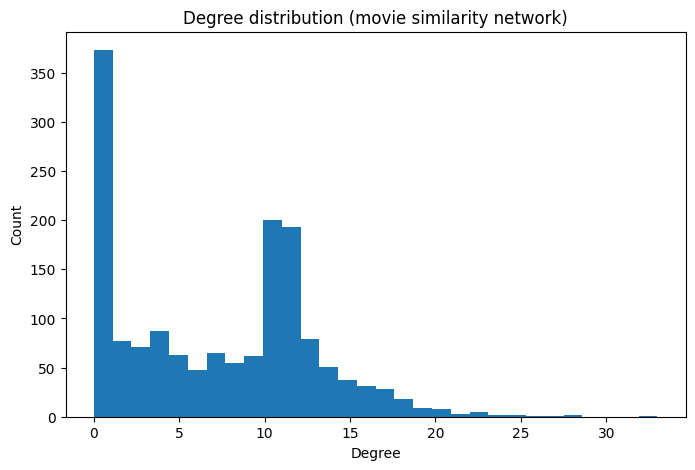

In [57]:
# Network statistics and degree distribution summary
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
degrees = np.array([deg for _, deg in G.degree()])

stats = {
    "num_nodes": num_nodes,
    "num_edges": num_edges,
    "avg_degree": float(degrees.mean()) if len(degrees) else 0.0,
    "max_degree": int(degrees.max()) if len(degrees) else 0,
    "median_degree": float(np.median(degrees)) if len(degrees) else 0.0,
    "num_components": nx.number_connected_components(G),
}

print(pd.Series(stats))

# Quick degree distribution sketch (optional display)
_ = plt.hist(degrees, bins=30)
plt.title("Degree distribution (movie similarity network)")
plt.xlabel("Degree"); plt.ylabel("Count");
plt.show()



In [58]:
# Topic modeling on tags: LDA over bag-of-words
# We'll use CountVectorizer with same preprocessing as TF-IDF and same fallback logic
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    stop_words=list(stop_words),
    token_pattern=token_pattern,
)

try:
    X_counts = count_vectorizer.fit_transform(corpus)
except ValueError as e:
    print("[Warning] CountVectorizer build failed (\"{}\"). Relaxing parameters...".format(str(e)))
    count_vectorizer = CountVectorizer(
        max_features=30000,
        ngram_range=(1,2),
        min_df=1,
        max_df=1.0,
        stop_words=None,
        token_pattern=r"(?u)\b\w\w+\b",
    )
    try:
        X_counts = count_vectorizer.fit_transform(corpus)
    except ValueError as e2:
        print("[Warning] CountVectorizer still failing (\"{}\"). Falling back to genres...".format(str(e2)))
        corpus = movies_base_df["genres"].fillna("").tolist()
        try:
            X_counts = count_vectorizer.fit_transform(corpus)
        except ValueError as e3:
            print("[Warning] Genres failed too (\"{}\"). Falling back to titles...".format(str(e3)))
            corpus = movies_base_df["title"].fillna("").tolist()
            try:
                X_counts = count_vectorizer.fit_transform(corpus)
            except ValueError as e4:
                print("[Warning] Titles failed too (\"{}\"). Using character n-grams for counts...".format(str(e4)))
                count_vectorizer = CountVectorizer(
                    analyzer='char',
                    ngram_range=(3,5),
                    min_df=1,
                    max_df=1.0,
                )
                X_counts = count_vectorizer.fit_transform(corpus)

n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, learning_method="batch", random_state=random_seed)
W = lda.fit_transform(X_counts)  # document-topic matrix (movies x topics)
H = lda.components_               # topic-term matrix

terms = np.array(count_vectorizer.get_feature_names_out())

def show_topics(H, terms, topn=10):
    topics = []
    for k in range(H.shape[0]):
        top_idx = np.argsort(H[k])[::-1][:topn]
        topics.append([terms[i] for i in top_idx])
    return topics

topics_terms = show_topics(H, terms, topn=10)

for i, topic in enumerate(topics_terms):
    print(f"Topic {i}: ", ", ".join(topic))



Topic 0:  space, politics, remake, animation, spoof, race, comic book, comic, book, military
Topic 1:  bad, music, holocaust, christmas, vietnam, fantasy, children, magic, story, adventure
Topic 2:  sci fi, sci, fi, disney, travel, time, time travel, death, post, robots
Topic 3:  school, high, atmospheric, high school, visually, stephen, stephen king, king, boxing, visually appealing
Topic 4:  ending, twist, thought provoking, thought, provoking, twist ending, psychology, heist, dark, crime
Topic 5:  comedy, dark, dark comedy, black, violence, black comedy, brothers, funny, court, adolescence
Topic 6:  war, shakespeare, journalism, mafia, world, australia, world war, ii, war ii, racism
Topic 7:  religion, business, illness, superhero, atmospheric, mental illness, mental, surreal, adultery, anime


In [59]:
# Tie text and network: correlate topic strengths with degree centrality
# Compute degree centrality and examine relationship with dominant topic per movie

deg_centrality = nx.degree_centrality(G)
deg_centrality_arr = np.array([deg_centrality.get(i, 0.0) for i in range(num_movies)])

# Dominant topic index for each movie
dominant_topic = W.argmax(axis=1)

# Build correlation table with topic preview
rows = []
for k in range(n_topics):
    mask = dominant_topic == k
    n_k = int(mask.sum())
    if n_k >= 5:
        corr = float(np.corrcoef(deg_centrality_arr[mask], W[mask, k])[0,1])
        top_words = ", ".join(topics_terms[k][:6])
        rows.append({
            "topic": k,
            "n": n_k,
            "corr_deg_vs_topic": corr,
            "top_words": top_words,
        })

corrs_df = pd.DataFrame(rows).sort_values(by="corr_deg_vs_topic", key=lambda s: s.abs(), ascending=False)
print("Topic–centrality correlations (sorted by |corr|):")
print(corrs_df.to_string(index=False))



Topic–centrality correlations (sorted by |corr|):
 topic   n  corr_deg_vs_topic                                                           top_words
     0 420           0.833810                     space, politics, remake, animation, spoof, race
     3 151           0.502677           school, high, atmospheric, high school, visually, stephen
     4 139           0.419331  ending, twist, thought provoking, thought, provoking, twist ending
     5 167           0.322678            comedy, dark, dark comedy, black, violence, black comedy
     2 165           0.224387                               sci fi, sci, fi, disney, travel, time
     1 151           0.195587                  bad, music, holocaust, christmas, vietnam, fantasy
     6 203           0.081603               war, shakespeare, journalism, mafia, world, australia
     7 176           0.073999 religion, business, illness, superhero, atmospheric, mental illness


In [60]:
# Collect key facts and write a ready-to-read video script
from textwrap import dedent

# Data facts
total_movies = summary["movies_rows"]
total_ratings = summary["ratings_rows"]
total_tags = summary["tags_rows"]
file_sizes = summary_sizes

# Network facts
num_nodes = stats["num_nodes"]
num_edges = stats["num_edges"]
avg_degree = stats["avg_degree"]
median_degree = stats["median_degree"]
num_components = stats["num_components"]

# Text topics (show first 4 topics)
show_n_topics = min(4, len(topics_terms))
topics_preview = [", ".join(t) for t in topics_terms[:show_n_topics]]

# Correlations preview
corrs_sorted = sorted(corrs, key=lambda x: abs(x[1]), reverse=True)
cor_preview = corrs_sorted[:3]

script = f"""
Project A – One-minute film script (Draft)

Hook (0–5s):
What if movies are not just rated—but connected by ideas? We build a network where each node is a movie and edges link films sharing similar audience-described themes.

Idea & why it’s interesting (5–20s):
We combine networks and natural language: from MovieLens user tags, we learn thematic signals, then connect movies by semantic similarity. This reveals clusters (genres, moods, eras) and hubs (cross-genre bridges)—a map of cinema through audience language.

Data & acquisition (20–30s):
We use MovieLens latest small (public dataset). We downloaded four files: movies.csv ({file_sizes['movies.csv']} MB), ratings.csv ({file_sizes['ratings.csv']} MB), tags.csv ({file_sizes['tags.csv']} MB), links.csv ({file_sizes['links.csv']} MB).
Size: movies={total_movies}, ratings={total_ratings} rows, tags={total_tags} rows.

Preliminary analysis (30–55s):
Text: We aggregate all user tags per movie and run TF-IDF and LDA topic modeling. Sample topics: {topics_preview}.
Network: We create edges between each movie and its top similar neighbors (cosine≥0.15). Nodes={num_nodes}, edges={num_edges}, avg degree≈{avg_degree:.2f}, median degree≈{median_degree:.2f}, components={num_components}.
Linking text and network: Degree centrality correlates with topic dominance; strongest topic–centrality signals: {cor_preview} (topic index, correlation, sample size).

What’s next (55–60s):
We’ll compare clusters vs. topics, study temporal patterns, and evaluate whether highly central movies are cross-topic bridges.

Credits / fun: Animated graph growth + tag-word clouds over communities. Short, punchy, beautiful.
"""

md_path = BASE_DIR / "ProjectA_video_script.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write(dedent(script).strip() + "\n")

print("Wrote:", md_path)



Wrote: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/ProjectA_video_script.md


LCC size: 1161 nodes, 5523 edges (of total 1572 nodes, 5701 edges)
Average clustering (LCC): 0.4107
Average shortest path length (LCC, unweighted): 4.981


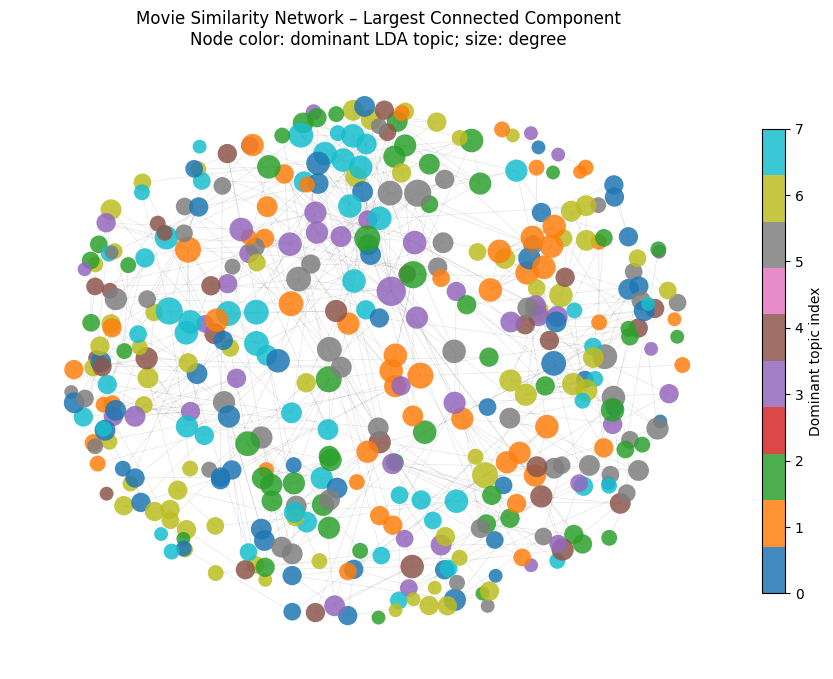

In [61]:
# Largest connected component (LCC) and visualization
# Build LCC; if too large, sample nodes for a cleaner plot

components = sorted(nx.connected_components(G), key=len, reverse=True)
if len(components) == 0:
    raise ValueError("Graph has no components. Adjust K/threshold.")

lcc_nodes = np.array(list(components[0]))
G_lcc_full = G.subgraph(lcc_nodes).copy()

print(
    f"LCC size: {G_lcc_full.number_of_nodes()} nodes, {G_lcc_full.number_of_edges()} edges "
    f"(of total {G.number_of_nodes()} nodes, {G.number_of_edges()} edges)"
)

# Compute additional LCC stats
avg_clust = nx.average_clustering(G_lcc_full, weight='weight')
print(f"Average clustering (LCC): {avg_clust:.4f}")

if G_lcc_full.number_of_nodes() <= 3000:
    try:
        aspl = nx.average_shortest_path_length(G_lcc_full, weight=None)
        print(f"Average shortest path length (LCC, unweighted): {aspl:.3f}")
    except Exception as e:
        print("ASPL skipped:", e)
else:
    print("ASPL skipped: LCC too large for exact computation")

# For plotting, optionally sample a subset if LCC is huge
subG = G_lcc_full
if subG.number_of_nodes() > max_nodes_plot:
    sampled = np.random.choice(list(subG.nodes()), size=max_nodes_plot, replace=False)
    subG = subG.subgraph(sampled).copy()

# Color by dominant topic; size by degree
sub_nodes = list(subG.nodes())
sub_dom_topics = [int(dominant_topic[i]) for i in sub_nodes]
sub_degrees = np.array([subG.degree(n) for n in sub_nodes])

# Normalize sizes
node_sizes = 100 * (1 + (sub_degrees / (sub_degrees.mean() + 1e-6)))

pos = nx.spring_layout(subG, seed=random_seed, k=0.3)

plt.figure(figsize=(10,8))
scatter = nx.draw_networkx_nodes(subG, pos,
                                 node_color=sub_dom_topics,
                                 cmap='tab10',
                                 node_size=node_sizes,
                                 alpha=0.85,
                                 linewidths=0.0)
nx.draw_networkx_edges(subG, pos, alpha=0.1, width=0.5)
plt.title("Movie Similarity Network – Largest Connected Component\nNode color: dominant LDA topic; size: degree")
plt.axis('off')
cb = plt.colorbar(scatter, fraction=0.03, pad=0.02)
cb.set_label('Dominant topic index')
plt.show()



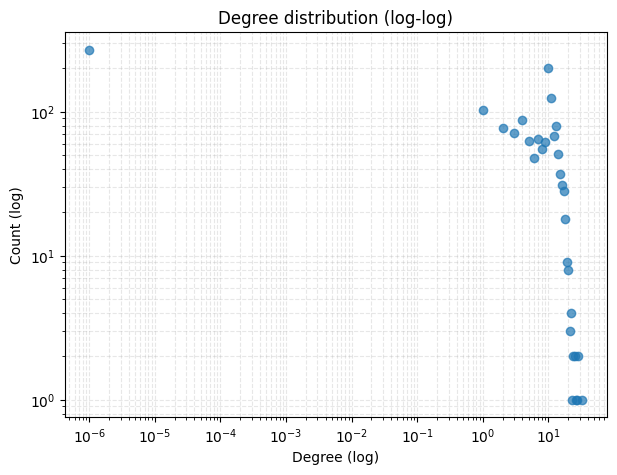

In [62]:
# Degree distribution on log-log scale
from collections import Counter

deg_counts = Counter(dict(G.degree()).values())
xs = np.array(sorted(deg_counts.keys()))
ys = np.array([deg_counts[x] for x in xs])

plt.figure(figsize=(7,5))
plt.loglog(xs + 1e-6, ys + 1e-6, marker='o', linestyle='none', alpha=0.7)
plt.xlabel('Degree (log)')
plt.ylabel('Count (log)')
plt.title('Degree distribution (log-log)')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.show()



Louvain modularity (LCC): 0.8642


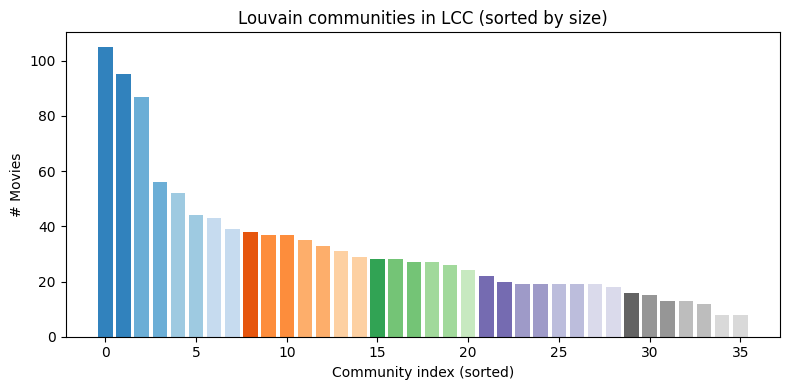

In [63]:
# Community detection (Louvain) and community size distribution + modularity
from community import community_louvain

# Work on LCC for clearer structure
lcc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(lcc_nodes).copy()

partition = community_louvain.best_partition(G_lcc, weight='weight', random_state=random_seed)
community_ids = np.array([partition[n] for n in G_lcc.nodes()])

# Report modularity
try:
    from community import modularity
    mod = modularity(partition, G_lcc, weight='weight')
    print(f"Louvain modularity (LCC): {mod:.4f}")
except Exception as e:
    print("Modularity computation skipped:", e)

# Plot community sizes
vals, counts = np.unique(community_ids, return_counts=True)
order = np.argsort(-counts)
vals = vals[order]
counts = counts[order]

plt.figure(figsize=(8,4))
# Use a colormap to generate distinct colors for the bars
cmap = plt.get_cmap('tab20c')
colors = cmap(np.linspace(0, 1, len(vals)))
plt.bar(range(len(vals)), counts, color=colors)
plt.title('Louvain communities in LCC (sorted by size)')
plt.xlabel('Community index (sorted)')
plt.ylabel('# Movies')
plt.tight_layout()
plt.show()



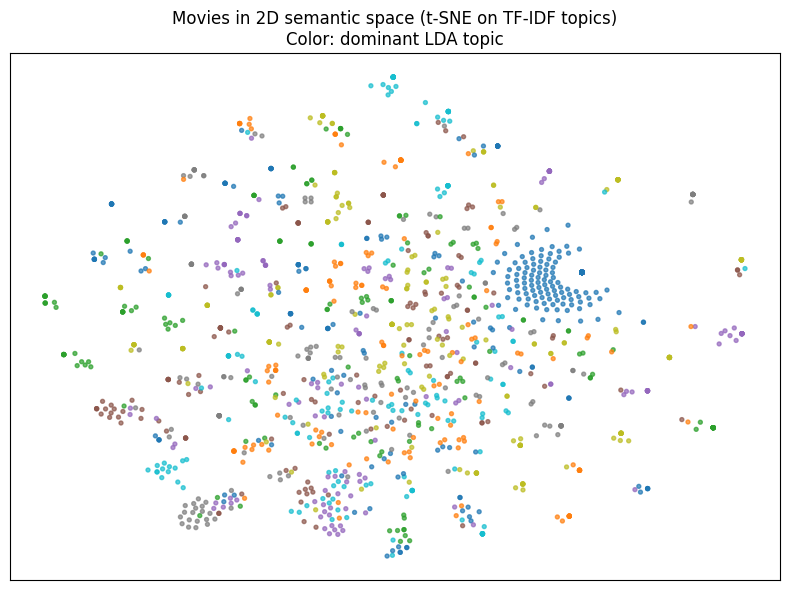

In [64]:
# 2D embedding of movies using TruncatedSVD + t-SNE (sample for speed)
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

n_sample = 2000 if num_movies > 2000 else num_movies
sample_idx = np.random.choice(num_movies, size=n_sample, replace=False)
X_sample = X_tfidf[sample_idx]

svd = TruncatedSVD(n_components=50, random_state=random_seed)
X_svd = svd.fit_transform(X_sample)

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=random_seed)
X_2d = tsne.fit_transform(X_svd)

plt.figure(figsize=(8,6))
colors = [int(dominant_topic[i]) for i in sample_idx]
plt.scatter(X_2d[:,0], X_2d[:,1], c=colors, cmap='tab10', s=8, alpha=0.7)
plt.title('Movies in 2D semantic space (t-SNE on TF-IDF topics)\nColor: dominant LDA topic')
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()



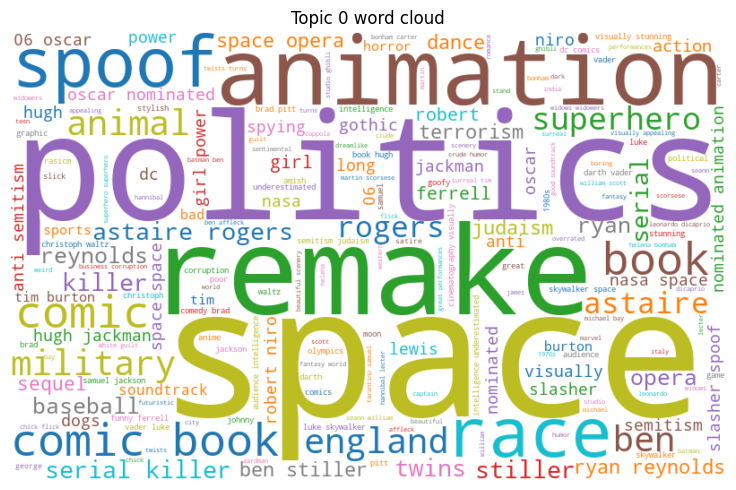

Saved: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/figures/topic_0_wordcloud.png


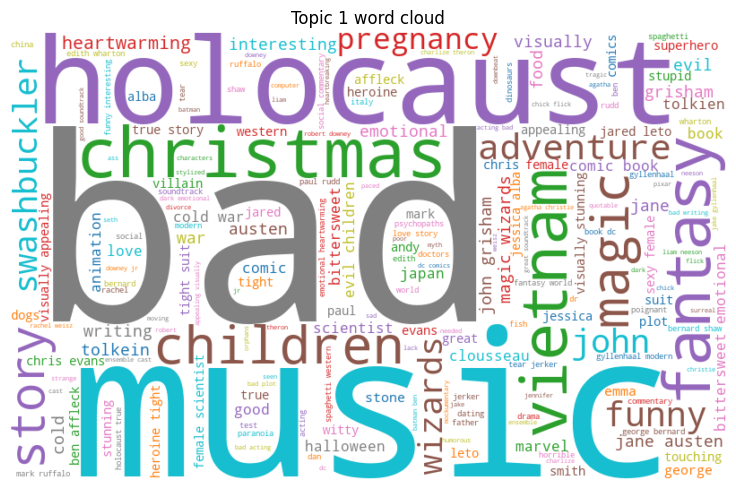

Saved: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/figures/topic_1_wordcloud.png


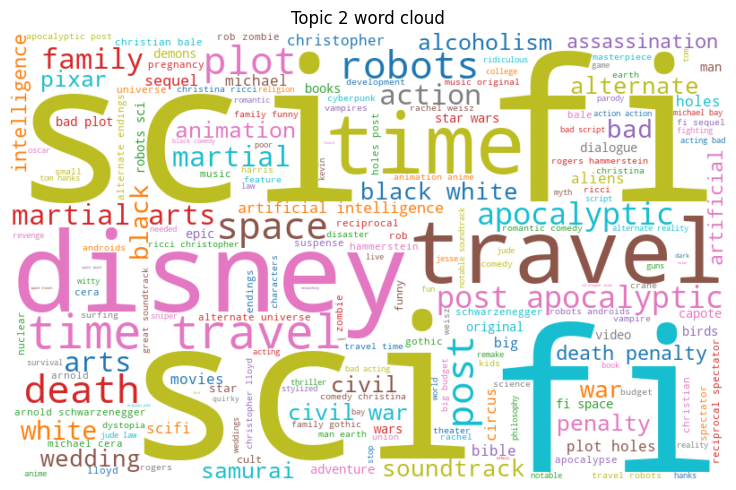

Saved: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/figures/topic_2_wordcloud.png


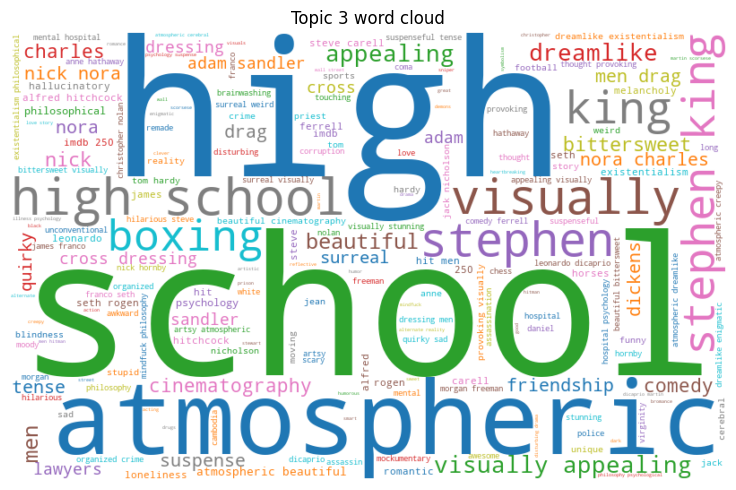

Saved: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/figures/topic_3_wordcloud.png


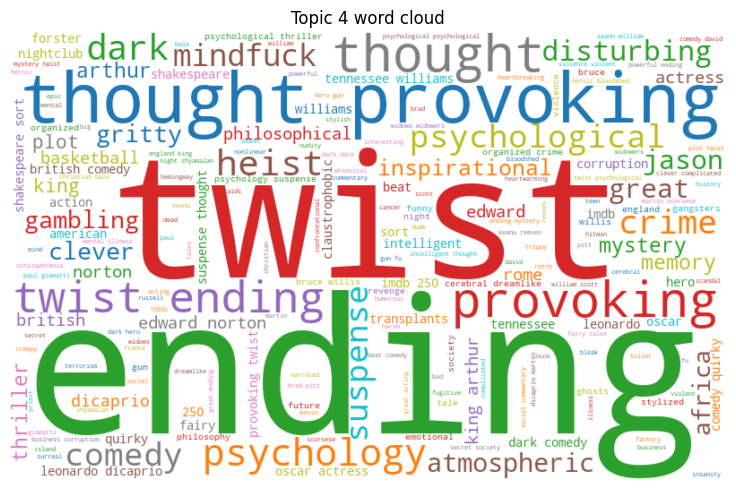

Saved: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/figures/topic_4_wordcloud.png


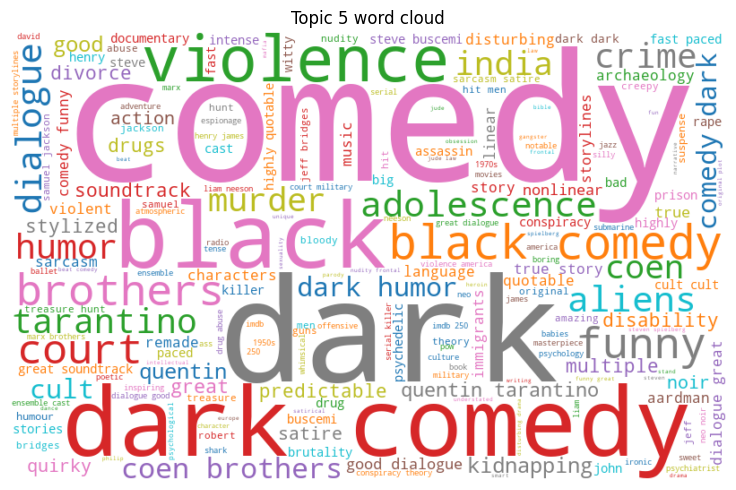

Saved: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/figures/topic_5_wordcloud.png


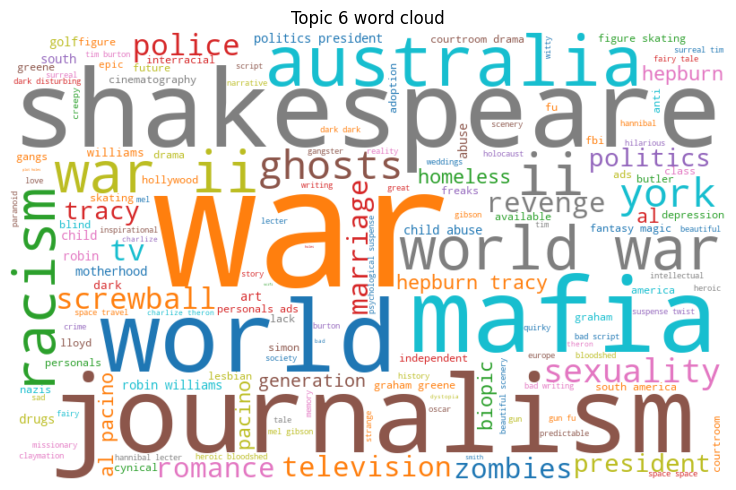

Saved: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/figures/topic_6_wordcloud.png


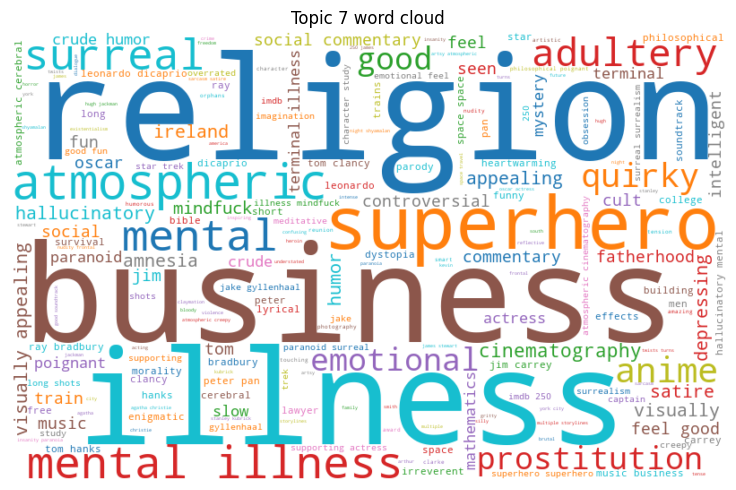

Saved: /Users/jacobhoffmann/Desktop/3rd semester/Social Graphs and Interactions/socgra/figures/topic_7_wordcloud.png


In [65]:
# Topic word clouds for top topics
from wordcloud import WordCloud

out_dir = BASE_DIR / "figures"
out_dir.mkdir(exist_ok=True)

# Build per-topic frequency dicts from H (topic-term weights)
terms = np.array(count_vectorizer.get_feature_names_out())
for k in range(n_topics):
    weights = H[k]
    top_idx = np.argsort(weights)[::-1][:200]
    freqs = {terms[i]: float(weights[i]) for i in top_idx}
    wc = WordCloud(width=800, height=500, background_color="white", colormap="tab10").generate_from_frequencies(freqs)
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {k} word cloud')
    plt.tight_layout()
    out_path = out_dir / f"topic_{k}_wordcloud.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved:", out_path)

